# <center> Figures for PGx Position Paper </center>
--- 

## 1. Setting up environment

 Load rpy2 package to use both R and python within the same notebook.

In [2]:
%load_ext rpy2.ipython


Import python packages and R libraries.

In [3]:
import glob
from itertools import product
import pandas as pd
import plotly.graph_objects as go
import os
import re

import pypgx

from utils import *

In [4]:
%%R 
library("dplyr")
library("ggplot2")
library("patchwork")
library("tidyverse")

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v stringr   1.5.1
v lubridate 1.9.3     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.1
v readr     2.1.5     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Define global variables.

In [5]:
PHARMVAR_DIR = "/mnt/c/Users/VDMAASS/PGx/PGx-position-paper/PharmVar_databases"

## 2. Creating Figures.

### 2.1 Sankey plot of star alleles throughout versions of PharmVar

In [17]:
allele_df = generate_pharmvar_historical_data(PHARMVAR_DIR)
allele_df.to_excel("/mnt/c/Users/VDMAASS/PGx/PGx-position-paper/star_allele_data.xlsx")
print(allele_df.head())
allele_df["Allele"] = allele_df["Allele"].apply(keep_major_allele)
allele_df_keep = allele_df[["Allele", "Version"]]
allele_df_collapsed = allele_df_keep.drop_duplicates(subset = ["Allele", "Version"])

unique_alleles = allele_df_collapsed["Allele"].unique()
unique_alleles.sort()

sankey_df = pd.DataFrame({'Allele': unique_alleles})
versions = allele_df_collapsed['Version'].unique()

for version in versions:
    sankey_df[version] = sankey_df['Allele'].isin(allele_df_collapsed[allele_df_collapsed['Version'] == version]['Allele']).astype(int)


sankey_df = compare_versions_counts(sankey_df)
nodes, links, x_positions, y_positions = generate_sankey_data(sankey_df)
fig = create_sankey_plot(nodes, links, x_positions, y_positions)

fig.write_html("/mnt/c/Users/VDMAASS/PGx/PGx-position-paper/figures/major_release_pharmvar_sankey_diagram.html")



OSError: Cannot save file into a non-existent directory: '/mnt/C/Users/VDMAASS/PGx/PGX-position-paper'

### 2.2 Stacked Line chart of star alleles throughout versions of PharmVar

In [7]:
allele_df = generate_pharmvar_historical_data(PHARMVAR_DIR)
allele_df = allele_df[["Allele", "Gene", "Date", "Version"]]
# Remove duplicates based on Allele and Version
allele_df_collapsed = allele_df.drop_duplicates(subset = ["Allele", "Version"])
# Remove the .001 alleles, as these are duplicates of the *1 reference alleles.
allele_df_collapsed = allele_df_collapsed[~allele_df_collapsed['Allele'].str.endswith(".001")].reset_index(drop = True) 
# Categorize the alleles based on sub or core allele.
allele_df_collapsed["allele_type"] = allele_df_collapsed["Allele"].apply(categorize_alleles)
# convert to tidy df and add a count column for the amount of core-alleles and sub-alleles per date
tidy_df = allele_df_collapsed.groupby(["Date", "allele_type"]).size().reset_index(name = "Count")

print(tidy_df)

          Date  allele_type  Count
0   2018-05-22  core-allele    193
1   2018-05-22   sub-allele     62
2   2018-07-27  core-allele    246
3   2018-07-27   sub-allele     90
4   2018-11-05   sub-allele     90
5   2019-05-07  core-allele    199
6   2019-05-07   sub-allele    134
7   2021-08-02  core-allele    362
8   2021-08-02   sub-allele    305
9   2023-05-12  core-allele    504
10  2023-05-12   sub-allele    381
11  2024-06-28  core-allele    563
12  2024-06-28   sub-allele    435


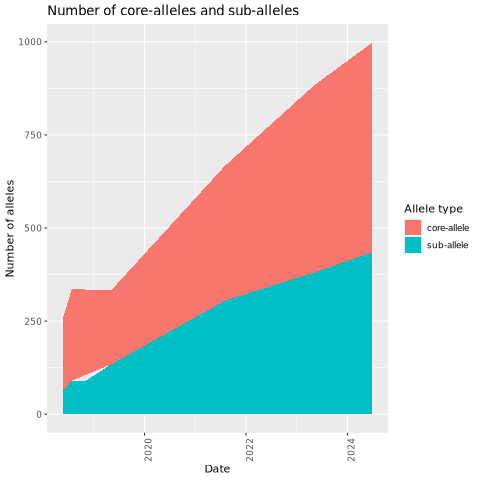

In [8]:
%%R -i tidy_df

tidy_df %>%
    mutate(Date = as.Date(Date, format = "%Y-%m-%d")) -> tidy_df

ggplot(tidy_df, aes(x = Date, y = Count, fill = allele_type)) +
    geom_area(stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = "Number of core-alleles and sub-alleles",
         x = "Date",
         y = "Number of alleles",
         fill = "Allele type")


### 2.3 Visualize updated calls and their impact

2.3.1 Generate a stacked bar plot depicting the number of updated calls per gene compared to the GeT-RM dataset.

In [9]:
all_calls = (pd.read_excel("/mnt/c/Users/VDMAASS/PGx/PGx-position-paper/Supplemental_Experiments_Aldy2023.xlsx",
                        sheet_name = "Short Reads",
                        header = 1)
                        .filter(["Sample", "Gene", "GeT-RM", "Updated Call"])
                        .reset_index())


all_calls["Updated Call"] = all_calls["Updated Call"].notnull().replace({True: "Updated", False: "Not_updated"})


# group by gene and count the amount of updated and not updated calls per gene and convert to tidy format
all_calls = all_calls.groupby("Gene")["Updated Call"].value_counts().unstack().fillna(0).reset_index()
# convert to tidy format
all_calls_tidy = pd.melt(all_calls, id_vars = "Gene",  value_vars = ["Not_updated", "Updated"], value_name = "Count")
# sort values by Gene
all_calls_tidy = all_calls_tidy.sort_values(["Updated Call", "Count"], ascending = [False, False])
# rename columns
all_calls_tidy = all_calls_tidy.rename(columns = {"Updated Call": "Updated_calls"}).reset_index(drop = True)
# skip DPYD



print(all_calls_tidy)

       Gene Updated_calls  Count
0      DPYD       Updated   46.0
1   SLCO1B1       Updated   43.0
2    CYP2B6       Updated   41.0
3    CYP1A1       Updated   31.0
4   CYP2A13       Updated   20.0
5    CYP2A6       Updated   13.0
6    CYP4F2       Updated   11.0
7   CYP3A43       Updated   10.0
8    CYP3A7       Updated    7.0
9    CYP2C8       Updated    5.0
10   CYP2S1       Updated    4.0
11  CYP2C19       Updated    3.0
12   CYP1A2       Updated    1.0
13   CYP2C9       Updated    1.0
14   CYP2J2       Updated    1.0
15   CYP2D6       Updated    0.0
16   CYP3A4       Updated    0.0
17   CYP3A5       Updated    0.0
18     TPMT       Updated    0.0
19   CYP2D6   Not_updated  137.0
20   CYP3A4   Not_updated  137.0
21   CYP3A5   Not_updated  137.0
22     TPMT   Not_updated  137.0
23   CYP2C9   Not_updated  136.0
24  CYP2C19   Not_updated  134.0
25   CYP2C8   Not_updated  132.0
26   CYP4F2   Not_updated  126.0
27   CYP2A6   Not_updated  124.0
28   CYP2B6   Not_updated   96.0
29   CYP1A

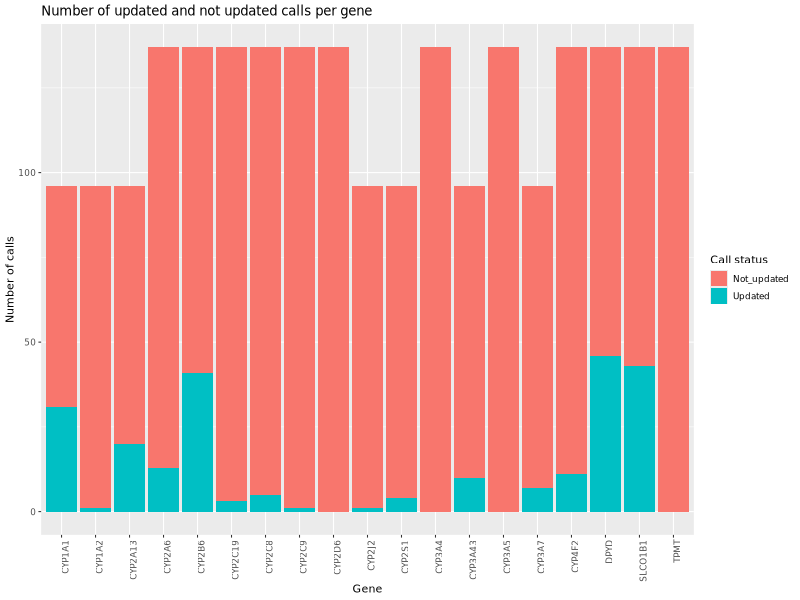

In [10]:
%%R -i all_calls_tidy -w 800 -h 600

ggplot(all_calls_tidy, aes(x = Gene, y = Count, fill = Updated_calls)) +
    geom_bar(stat = "identity", position = "stack") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = "Number of updated and not updated calls per gene",
         x = "Gene",
         y = "Number of calls",
         fill = "Call status")


2.3.2 Stacked bar plot depicting the types of changes for every updated call.

In [11]:
updated_calls_df = (pd.read_excel("/mnt/c/Users/VDMAASS/PGx/PGx-position-paper/Supplemental_Experiments_Aldy2023.xlsx",
                     sheet_name = "Short Reads",
                     header = 1)
                     .filter(["Sample", "Gene", "GeT-RM", "Updated Call"])
                     .dropna()
                     .reset_index())
updated_calls_df = updated_calls_df[~ (updated_calls_df["Updated Call"].str.contains("?", regex = False) |
                                       updated_calls_df["Updated Call"].str.contains("*", regex = False))]

# Process the diplotype patterns for easy comparison
updated_calls_df["GeT-RM"] = updated_calls_df["GeT-RM"].apply(process_diplotype_patterns)
updated_calls_df["Updated Call"] = updated_calls_df["Updated Call"].apply(process_diplotype_patterns)

# Create lists of haplotypes from the diplotypes
updated_calls_df["GeT-RM"] = updated_calls_df["GeT-RM"].apply(create_list_of_haplotypes_from_diplotype)
updated_calls_df["Diplotype_lists"] = updated_calls_df["Updated Call"].apply(create_list_of_haplotypes_from_diplotype)
# Predict the phenotypes for the updated diplotypes using the pypgx package
updated_calls_df["Updated_phenotype"] = updated_calls_df.apply(lambda x: list(set(predict_phenotypes(x["Gene"], x["Diplotype_lists"]))), axis = 1)
updated_calls_df["Original_phenotype"] = updated_calls_df.apply(lambda x: list(set(predict_phenotypes(x["Gene"], x["GeT-RM"]))), axis = 1)
# Check if any of the updated phenotypes are in the original phenotypes
updated_calls_df["Phenotype_Match"] = updated_calls_df.apply(lambda x: any(phenotype in x["Original_phenotype"] for phenotype in x["Updated_phenotype"]), axis = 1)
# Check if any of the updated diplotypes are in the original diplotypes
updated_calls_df["Diplotype_Match"] = updated_calls_df.apply(lambda x: any(diplotype in x["GeT-RM"] for diplotype in x["Diplotype_lists"]), axis = 1)


/home/svenvdm/micromamba/envs/updated_diplotypes/lib/python3.12/site-packages/pypgx/api/core.py:1382: UserWarning:

*16 not found in the allele table for CYP2B6

/home/svenvdm/micromamba/envs/updated_diplotypes/lib/python3.12/site-packages/pypgx/api/core.py:1382: UserWarning:

*17 not found in the allele table for SLCO1B1

/home/svenvdm/micromamba/envs/updated_diplotypes/lib/python3.12/site-packages/pypgx/api/core.py:1382: UserWarning:

*21 not found in the allele table for SLCO1B1

/home/svenvdm/micromamba/envs/updated_diplotypes/lib/python3.12/site-packages/pypgx/api/core.py:1382: UserWarning:

*21 not found in the allele table for SLCO1B1

/home/svenvdm/micromamba/envs/updated_diplotypes/lib/python3.12/site-packages/pypgx/api/core.py:1382: UserWarning:

*21 not found in the allele table for SLCO1B1

/home/svenvdm/micromamba/envs/updated_diplotypes/lib/python3.12/site-packages/pypgx/api/core.py:1382: UserWarning:

*21 not found in the allele table for SLCO1B1

/home/svenvdm/micromamb

Analysis of the updated diplotypes.

In [12]:

# group by gene and count the number of non-matching phenotypes
gene_stats = (updated_calls_df.groupby('Gene').agg({
    'Diplotype_Match': 'sum',  # Assumes Diplotype_Match is boolean or 0/1
    'Phenotype_Match': 'sum',  # Assumes Phenotype_Match is boolean or 0/1
    'Gene': 'count'  # This gives the total number of rows (updated calls) for each gene
    }))
gene_stats.columns = ['Diplotype_Match', 'Phenotype_Match', 'Total_Updated_Calls']
gene_stats['Phenotype_Mismatch'] = gene_stats['Total_Updated_Calls'] - gene_stats['Phenotype_Match']
gene_stats['Diplotype_Mismatch'] = gene_stats['Total_Updated_Calls'] - gene_stats['Diplotype_Match']
# also in percentage
gene_stats['Phenotype_Mismatch_Percentage'] = gene_stats['Phenotype_Mismatch'] / gene_stats['Total_Updated_Calls'] * 100
gene_stats['Diplotype_Mismatch_Percentage'] = gene_stats['Diplotype_Mismatch'] / gene_stats['Total_Updated_Calls'] * 100
# calculate total for non-cumulative stacked bar chart plot
gene_stats["No_change"] = gene_stats["Total_Updated_Calls"] - gene_stats["Diplotype_Mismatch"] - gene_stats["Phenotype_Mismatch"]

# convert to tidy format
gene_stats_tidy = gene_stats.filter(["No_change", "Phenotype_Mismatch", "Diplotype_Mismatch"]).reset_index().melt(id_vars = "Gene", var_name = "Mismatch_Type", value_name = "Count")
print(gene_stats_tidy)

       Gene       Mismatch_Type  Count
0    CYP1A1           No_change      3
1    CYP1A2           No_change      0
2   CYP2A13           No_change      0
3    CYP2A6           No_change      7
4    CYP2B6           No_change     13
5   CYP2C19           No_change      3
6    CYP2C8           No_change      5
7    CYP2C9           No_change      1
8    CYP2J2           No_change      1
9    CYP2S1           No_change      1
10  CYP3A43           No_change      0
11   CYP3A7           No_change      1
12   CYP4F2           No_change     11
13  SLCO1B1           No_change     10
14   CYP1A1  Phenotype_Mismatch      0
15   CYP1A2  Phenotype_Mismatch      0
16  CYP2A13  Phenotype_Mismatch      0
17   CYP2A6  Phenotype_Mismatch      0
18   CYP2B6  Phenotype_Mismatch      7
19  CYP2C19  Phenotype_Mismatch      0
20   CYP2C8  Phenotype_Mismatch      0
21   CYP2C9  Phenotype_Mismatch      0
22   CYP2J2  Phenotype_Mismatch      0
23   CYP2S1  Phenotype_Mismatch      0
24  CYP3A43  Phenotype_Mi

Plotting

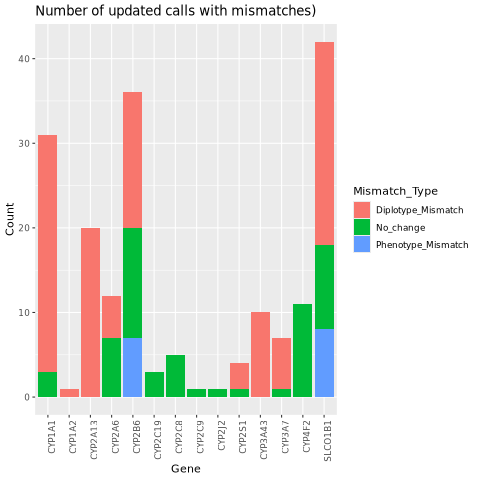

In [13]:
%%R -i gene_stats_tidy

ggplot(gene_stats_tidy, aes(x = Gene, y = Count, fill = Mismatch_Type)) +
    geom_bar(stat = "identity", position = "stack") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = "Number of updated calls with mismatches)")

### 2.3.2 Heatmap depicting the number of affected recommendations per gene-drug pair.

In [14]:
df = pypgx.load_cpic_table()
genes = gene_stats_tidy["Gene"].unique()

df = df[df["Gene"].isin(genes)]


# remove the rows that have a PharmGKB level of 4 or nan.
df = df[~df["PharmGKBLevel"].isin([4, "nan"])]
#
# df = df[df["CPICLevel"].isin(["A","B", "B/C"])]
df = df[["Gene", "Drug"]].reset_index(drop = True)



# number of drugs per gene
df = df.groupby("Gene")["Drug"].unique().reset_index()


drugs_cyp2b6 = list(set(df.iloc[0]["Drug"]))
drugs_slco1b1 = list(set(df.iloc[5]["Drug"]))

drug_associations = {
    "CYP2B6" : drugs_cyp2b6,
    "SLCO1B1" : drugs_slco1b1
}
print(drugs_cyp2b6)

def expand_row(row):
    drugs = drug_associations[row['Gene']]
    return pd.DataFrame({
        'Sample': [row['Sample']] * len(drugs),
        'Gene': [row['Gene']] * len(drugs),
        'Updated_phenotype': [row['Updated_phenotype']] * len(drugs),
        'Original_phenotype': [row['Original_phenotype']] * len(drugs),
        'Drug': drugs
    })

# print(updated_calls_df)
# keep only the rows that have a phenotype_mismatch

updated_calls_df = updated_calls_df[updated_calls_df["Phenotype_Match"] == False].reset_index(drop = True)


# print(updated_calls_df[["Sample", "Gene", "Updated_phenotype", "Original_phenotype"]])

# Add the drugs that are associated with the gene.
updated_calls_df = pd.concat(updated_calls_df.apply(expand_row, axis = 1).tolist(), ignore_index = True)
print(updated_calls_df)

['nevirapine', 'efavirenz', 'methadone', 'sertraline', 'bupropion']
      Sample     Gene    Updated_phenotype    Original_phenotype          Drug
0    NA18617   CYP2B6  [Rapid Metabolizer]  [Normal Metabolizer]    nevirapine
1    NA18617   CYP2B6  [Rapid Metabolizer]  [Normal Metabolizer]     efavirenz
2    NA18617   CYP2B6  [Rapid Metabolizer]  [Normal Metabolizer]     methadone
3    NA18617   CYP2B6  [Rapid Metabolizer]  [Normal Metabolizer]    sertraline
4    NA18617   CYP2B6  [Rapid Metabolizer]  [Normal Metabolizer]     bupropion
..       ...      ...                  ...                   ...           ...
102  NA20296  SLCO1B1      [Indeterminate]     [Normal Function]  atorvastatin
103  NA20296  SLCO1B1      [Indeterminate]     [Normal Function]   fluvastatin
104  NA20296  SLCO1B1      [Indeterminate]     [Normal Function]   simvastatin
105  NA20296  SLCO1B1      [Indeterminate]     [Normal Function]      elagolix
106  NA20296  SLCO1B1      [Indeterminate]     [Normal Function

In [15]:


def get_recommendation(drug: str, gene: str, phenotype: str) -> str:
    try:
        return pypgx.get_recommendation(drug, gene, phenotype)
    except ValueError:
        return "No recommendation found"

updated_calls_df["Original_Recommendation"] = updated_calls_df.apply(lambda x: get_recommendation(x["Drug"], x["Gene"], x["Original_phenotype"][0]), axis = 1)

updated_calls_df["Updated_Recommendation"] = updated_calls_df.apply(lambda x: get_recommendation(x["Drug"], x["Gene"], x["Updated_phenotype"][0]), axis = 1)

updated_calls_df.to_excel("/mnt/c/Users/VDMAASS/PGx/PGx-position-paper/recommendations_updated_calls.xlsx")

for _, row in updated_calls_df.iterrows():
    

print(updated_calls_df)
    


IndentationError: expected an indented block after 'for' statement on line 13 (3108611352.py, line 16)